In [27]:
import matplotlib.pyplot as plt
import numpy as np
import dataToVar as dat

In [28]:
def r2(y,fit):
    st = sum((y-np.average(y))**2)
    sr = sum((y-fit)**2)
    r2 = 1-sr/st
    return r2

## Offset Heat

1.0
offset = 0.07046005129043789 * therm + 3.2859631202298005


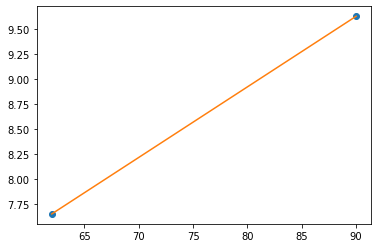

In [29]:
def r2surf(zlist,zlistfit):
    zlist = np.array(zlist)
    zlistfit = np.array(zlistfit)
    st = sum((zlist-np.average(zlist))**2)
    sr = sum((zlist-zlistfit)**2)
    r2 = 1-sr/st
    return r2

full = dat.modRetrainData                               #list of data has form of [time,thermister,sample]


def findOffset(setTemp1,setTemp2,setTemp3,ssEnd1,ssEnd2,ssEnd3):           
    offsetA = setTemp1 - np.average(full[2][ssEnd1-100:ssEnd1])           #find offsets by subtracting sample temp at ss from thermister temp
    offsetB = setTemp2 - np.average(full[2][ssEnd2-100:ssEnd2])            #setTemp = thermister temp @ss
                                                                            #ssEnd = index where steady state ends

    xx = np.array([setTemp1,setTemp2])
    yy = np.array([offsetA,offsetB])
    aa,bb = np.polyfit(xx,yy,1)                              #offset coeffs
    plt.plot(xx,yy,'o')
    plt.plot(xx,aa*xx+bb)
    
    ;
    print(r2(yy,aa*xx+bb))
    print('offset =',aa,'* therm +',bb)
    return aa,bb
aH,bH = findOffset(62,90,0,1300,3000,0)

aC = -0.004822680890538034
bC = 0.7402680890538067
cC = -18.674434137291467



## Kalman Loop

In [30]:
sampa = full[2][:]                                                   #temp of sample 
therma = full[1][:len(sampa)]        
                        
def findTrustVal(interval,type):                                             # loops through many possibilities for model coeffs and chooses the one with the highest r2 value
    if type == 'heat':                                                                    # adjust interval to refine model coeffs.
        samp = sampa[:3088]
        therm = full[1][:3088]
    elif type == 'cool':
        samp = sampa[3088:]
        therm = full[1][3088:len(sampa)]
    rr = {}


    big = np.arange(.8,1,interval)
    for i in big:
        zlistfit = []
        
        old = samp[0]
        

        for k in range(len(therm)):                                                 # if a called cell is blank in the csv, need to fill it before code will work
            if str(therm[k]) == 'nan':
                print('fix csv')
                break
            else:
                if type == 'heat':
                    offset = aH*therm[k]+bH
                else:
                    offset = aC*therm[k]**2+bC*therm[k]+cC
                old = old*i+(therm[k]-offset)*(1-i)
                zlistfit.append(old)

            

        r = r2surf(samp,zlistfit)
        if r >.8 and r<=1:
            rr[r] = i


    print('r2 =',max(rr)) 
    
    trust = rr[max(rr)] 
    print('a =',trust)
    # trust = .99802
    return trust

trust = findTrustVal(.0001,'heat')
trustC = findTrustVal(.0001,'cool')


r2 = 0.9982313050140394
a = 0.9956999999999785
r2 = 0.9934374932061859
a = 0.9986999999999782


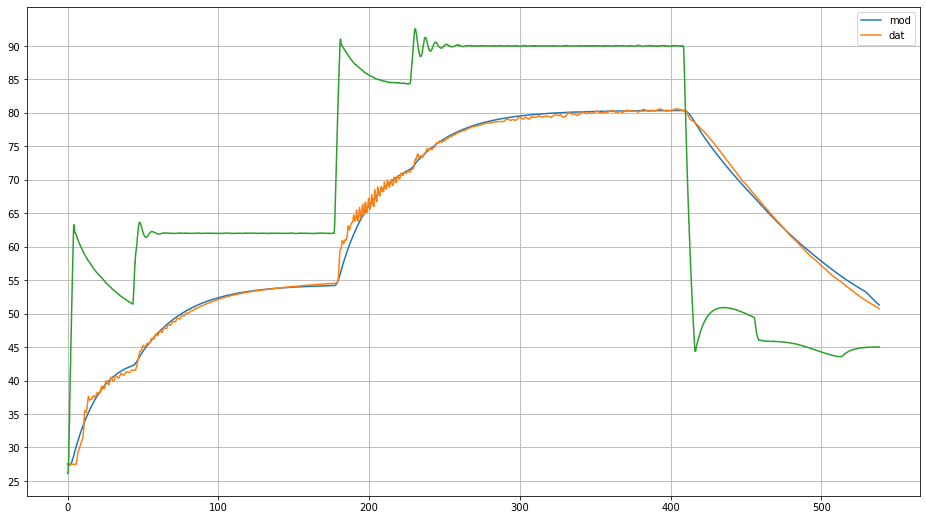

In [33]:
def plotMod():                                              #plot mod and sample
    plt.figure(figsize=(16,9))

    old = sampa[0]
    ans = []
    
    for k in range(len(therma)):
        if k <= 3088:
            offset = aH*therma[k]+bH
            old = old*trust+(therma[k]-offset)*(1-trust)
            ans.append(old)
        else:
            offset = aC*therma[k]**2+bC*therma[k]+cC
            old = old*trustC+(therma[k]-offset)*(1-trustC)
            ans.append(old)
    plt.plot(full[0][:len(sampa)],ans,label='mod')


    plt.plot(full[0][:len(sampa)],sampa,label='dat')
    plt.plot(full[0][:len(sampa)],therma) 
    plt.grid()
    plt.yticks(np.arange(25,95,5))
    plt.legend()
    ;
plotMod()